In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
import numpy as np
from scipy.stats import norm as normal
from zadania import BayesianLinearRegression

In [2]:
class Normal:
    def __init__(self, mean, sigma):
        assert isinstance(mean, float)
        assert isinstance(sigma, float)
        self.mean = mean
        self.sigma = sigma
    def pdf(self, x):
        return normal(self.mean, self.sigma).pdf(x)
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return rng.normal(self.mean, self.sigma, size=n_samples)

class Uniform:
    def __init__(self, mean, scale):
        assert isinstance(mean, float)
        assert isinstance(scale, float)
        self.mean = mean
        self.scale = scale
    def pdf(self, x):
        result = (np.abs(x - self.mean) <= .5 * self.scale)
        result = result.astype(np.float32).ravel() / (self.scale)
        return result
    def sample(self, n_samples, seed=43):
        rng = np.random.RandomState(seed=seed)
        return rng.uniform(self.mean - .5 * self.scale, self.mean + .5 * self.scale, size=n_samples)

def generate_observations(params, x_distr, noise_distr, n_samples, seed=43):
    x = x_distr.sample(n_samples, seed=4*seed)
    y = params[0] + x * params[1] + noise_distr.sample(n_samples, seed=3*seed)
    return x.reshape(-1,1), y.reshape(-1,1)


In [3]:
def draw_animation(
        grid_description, true_params, posteriors, conditional_ppds,
        likelihoods, true_conditional_pdf, true_x_pdf, obs):

    x_from, x_to, n_x, y_from, y_to, n_y = grid_description

    extent = [x_from, x_to, y_to, y_from]

    true_pdf = np.multiply(true_conditional_pdf, true_x_pdf).reshape(n_y, n_x)
    true_conditional_pdf = true_conditional_pdf.reshape(n_y, n_x)
    posteriors = np.stack([arr.reshape(n_y, n_x) for arr in posteriors])
    ppds = np.stack([np.multiply(arr, true_x_pdf).reshape(n_y, n_x) for arr in conditional_ppds])
    conditional_ppds = np.stack([arr.reshape(n_y, n_x) for arr in conditional_ppds])
    likelihoods = np.stack([arr.reshape(n_y, n_x) for arr in likelihoods])

    fig = plt.figure(figsize=(8, 12))

    ax1 = fig.add_subplot(3,2,1)
    ax1.set_title("Normalized Likelihood")
    ax2 = fig.add_subplot(3,2,2)
    ax2.set_title("Posterior")
    ax3 = fig.add_subplot(3,2,3)
    ax3.set_title("Conditional PPD")
    ax4 = fig.add_subplot(3,2,4)
    ax4.set_title("PPD")
    ax5 = fig.add_subplot(3,2,5)
    ax5.set_title("True Conditional Distribution")
    ax6 = fig.add_subplot(3,2,6)
    ax6.set_title("True Distribution")

    def draw(i):

        if not draw.initialized:
            
            draw.im_likelihood = ax1.imshow(
                likelihoods[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            ax1.scatter(true_params[0], true_params[1], s=50, marker='x', c='red')

            draw.im_posterior = ax2.imshow(
                posteriors[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            ax2.scatter(true_params[0], true_params[1], s=50, marker='x', c='red')
            
            draw.im_conditional_ppd = ax3.imshow(
                conditional_ppds[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            draw.s3 = ax3.scatter([], [], s=5)

            draw.im_ppd = ax4.imshow(
                ppds[0],
                extent=extent,
                cmap="inferno",
                animated=True)
            draw.s4 = ax4.scatter([], [], s=5)

            ax5.imshow(
                true_conditional_pdf,
                extent=extent,
                cmap="inferno")
            draw.s5 = ax5.scatter([], [], s=5)

            ax6.imshow(
                true_pdf,
                extent=extent,
                cmap="inferno")
            draw.s6 = ax6.scatter([], [], s=5)

            draw.initialized = True

        else:
        
            draw.im_likelihood.set_data(likelihoods[i])
            draw.im_likelihood.autoscale()

            draw.im_posterior.set_data(posteriors[i])
            draw.im_posterior.autoscale()

            draw.im_conditional_ppd.set_data(conditional_ppds[i])
            draw.im_conditional_ppd.autoscale()
            draw.s3.set_offsets(obs[:i])

            draw.im_ppd.set_data(ppds[i])
            draw.im_ppd.autoscale()
            draw.s4.set_offsets(obs[:i])

            draw.s5.set_offsets(obs[:i])
            draw.s6.set_offsets(obs[:i])

    draw.initialized=False
    
    return animation.FuncAnimation(fig, draw, range(len(ppds)+1), blit=True, interval=500, repeat=True)

In [4]:
def learning_history(bayesian_linear_regression, params, gridpoints_x, gridpoints_y, obs_x, obs_y):
    # w pętli:
    #   obserwujemy kolejny wylosowany punkt
    #   zapisujemy likelihood, posterior i ppd (potem będziemy ich używać przy rysowaniu animacji)
    posteriors = [bayesian_linear_regression.posterior]
    ppds = [bayesian_linear_regression.conditional_ppd(gridpoints_x, gridpoints_y)]
    # ustawiamy likelihood w zerowym kroku na jedynki
    # tak jest (chyba?) ładniej z matematycznego punktu widzenia
    likelihoods = [np.ones(len(params), dtype=np.float)]
    for i in trange(len(obs_x)):
        bayesian_linear_regression.observe(obs_x[i:i+1,:], obs_y[i:i+1,:])
        posteriors.append(bayesian_linear_regression.posterior.copy())
        ppds.append(bayesian_linear_regression.conditional_ppd(gridpoints_x, gridpoints_y).copy())
        likelihoods.append(bayesian_linear_regression.normalized_likelihood(obs_x[:i+1,:], obs_y[:i+1,:]))
    return posteriors, ppds, likelihoods

In [5]:
# W całym notebooku używamy dwuwymiarowej siatki parametrów
# na kwadracie [-3,3] x [-3,3]
# punkty rozmieszczone są co 0.2
#
# W razie potrzeby można ją zwiększyć/zmniejszyć/zagęścić/rozrzedzić

x_from, x_to, n_x = -3., 3., 31
y_from, y_to, n_y = -3., 3., 31
grid_description = [x_from, x_to, n_x, y_from, y_to, n_y]

_x = np.linspace(x_from, x_to, n_x)
_y = np.linspace(y_from, y_to, n_y)
params = np.transpose([np.tile(_x, len(_y)), np.repeat(_y, len(_x))])

gridpoints_x = params[:,0].reshape(-1,1)
gridpoints_y = params[:,1].reshape(-1,1)


100%|██████████| 15/15 [00:35<00:00,  2.36s/it]


<IPython.core.display.Javascript object>


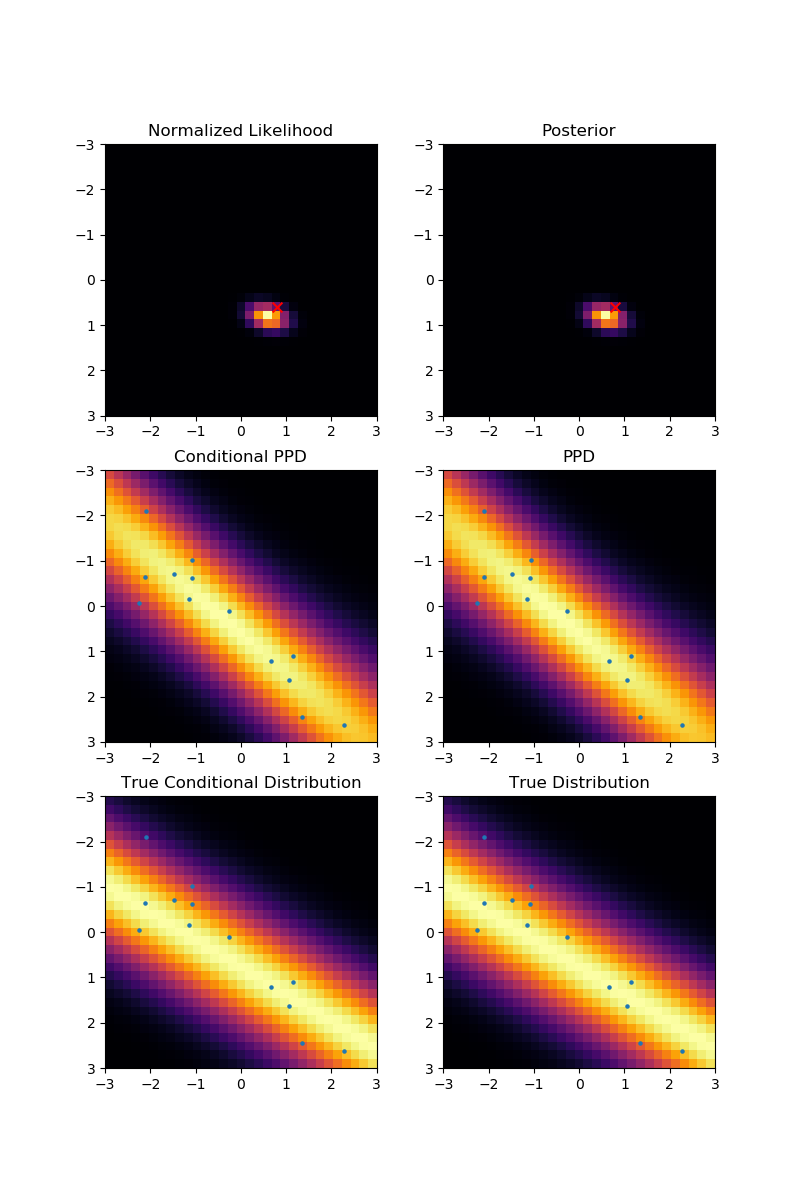

In [6]:
# PRZYKŁAD 1: KLASYCZNA REGRESJA LINIOWA

# wybieramy rozkład na x'ach
x_distr = Uniform(0., 6.)
# ustawiamy prawdziwy model: y = .6*x + .8 + N(0.,1.)
true_params = np.array([.8, .6])
noise_distr = Normal(0., 1.)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=15,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
uniform_prior = np.full(shape=len(params), fill_value=1./len(params))
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=noise_distr,
    params=params,
    prior=uniform_prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)

100%|██████████| 15/15 [00:35<00:00,  2.39s/it]


<IPython.core.display.Javascript object>


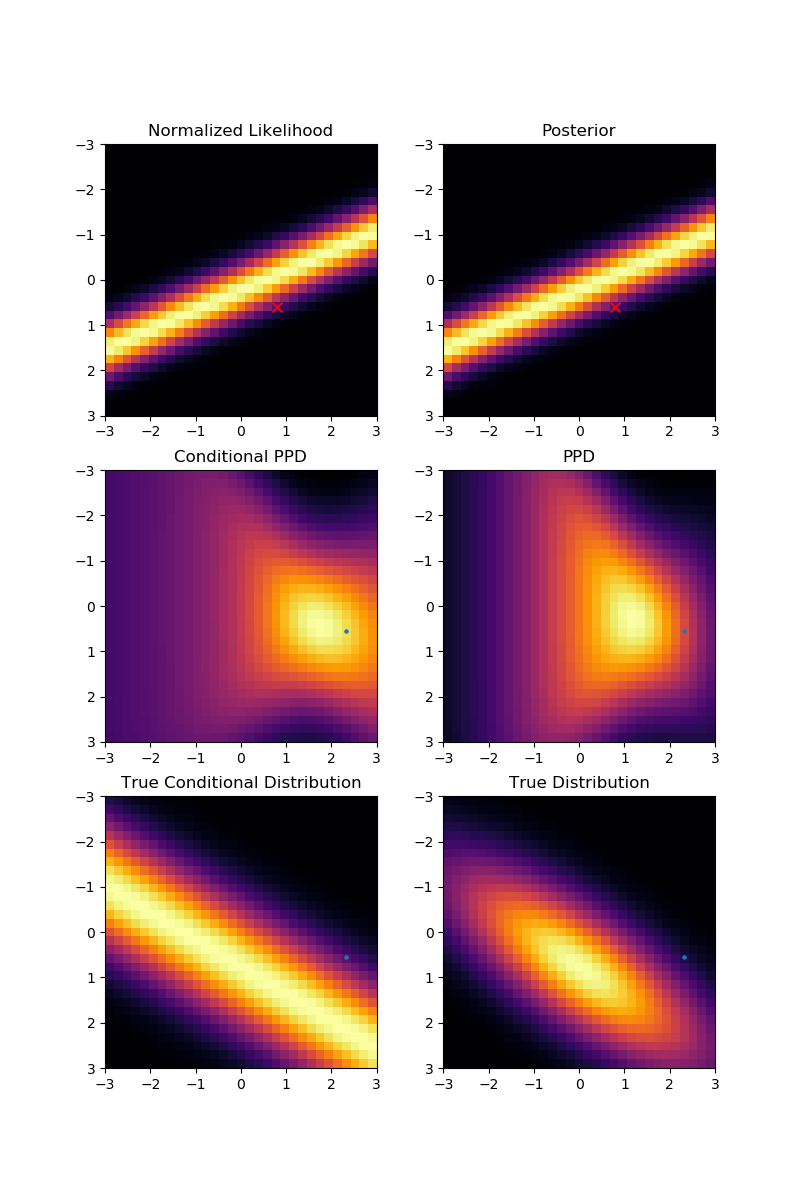

In [7]:
# PRZYKŁAD 2: X LOSOWANY Z ROZKŁADU NIEJEDNOSTAJNEGO

# wybieramy rozkład na x'ach
x_distr = Normal(0., 2.)
# ustawiamy prawdziwy model: y = .6*x + .8 + N(0.,1.)
true_params = np.array([.8, .6])
noise_distr = Normal(0., 1.)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=15,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
uniform_prior = np.full(shape=len(params), fill_value=1./len(params))
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=noise_distr,
    params=params,
    prior=uniform_prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)

100%|██████████| 30/30 [01:10<00:00,  2.36s/it]


<IPython.core.display.Javascript object>


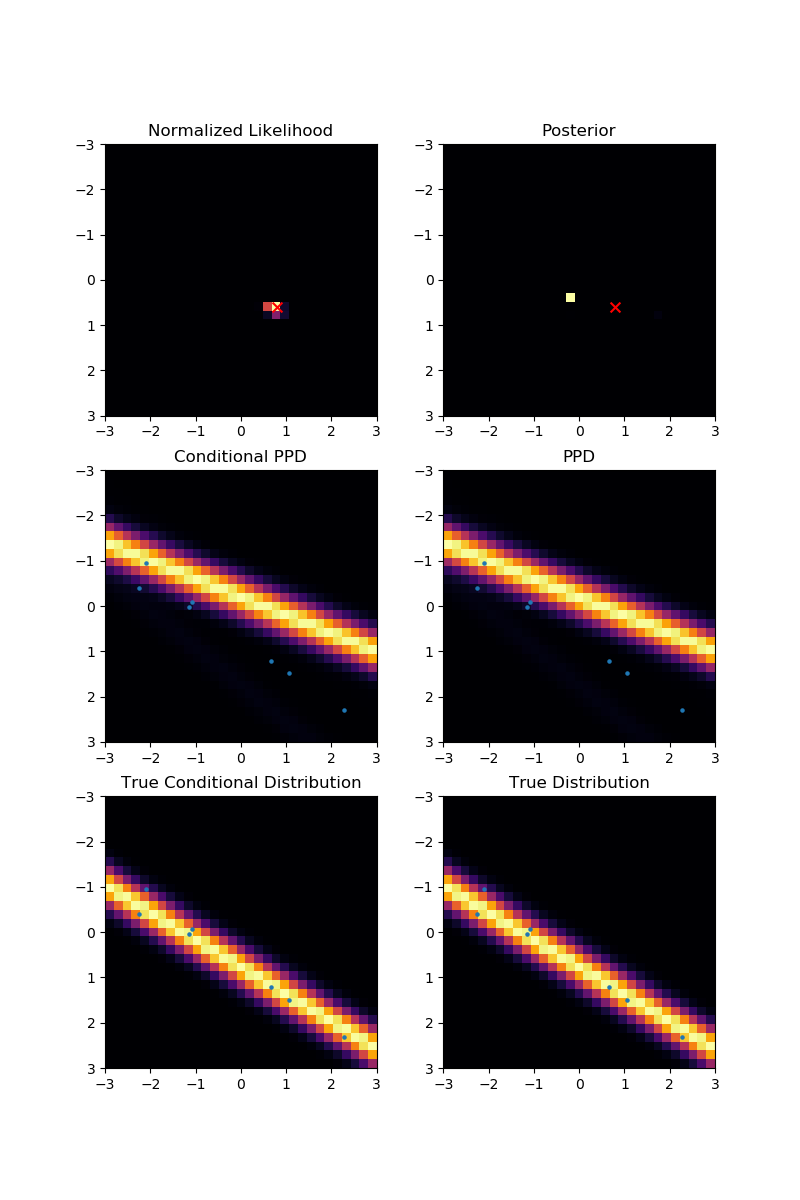

In [8]:
# PRZYKŁAD 3: ZEROWY PRIOR W OTOCZENIU L2 PRAWDZIWEGO PARAMETRU

# wybieramy rozkład na x'ach
x_distr = Uniform(0., 6.)
# ustawiamy prawdziwy model: y = .6*x + .8 + N(0.,.3)
true_params = np.array([.8, .6])
noise_distr = Normal(0., .3)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=30,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
prior = np.maximum(0., np.sum(np.square(params - true_params), axis=1) - 1.)
prior /= prior.sum()
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=noise_distr,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)

100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


<IPython.core.display.Javascript object>


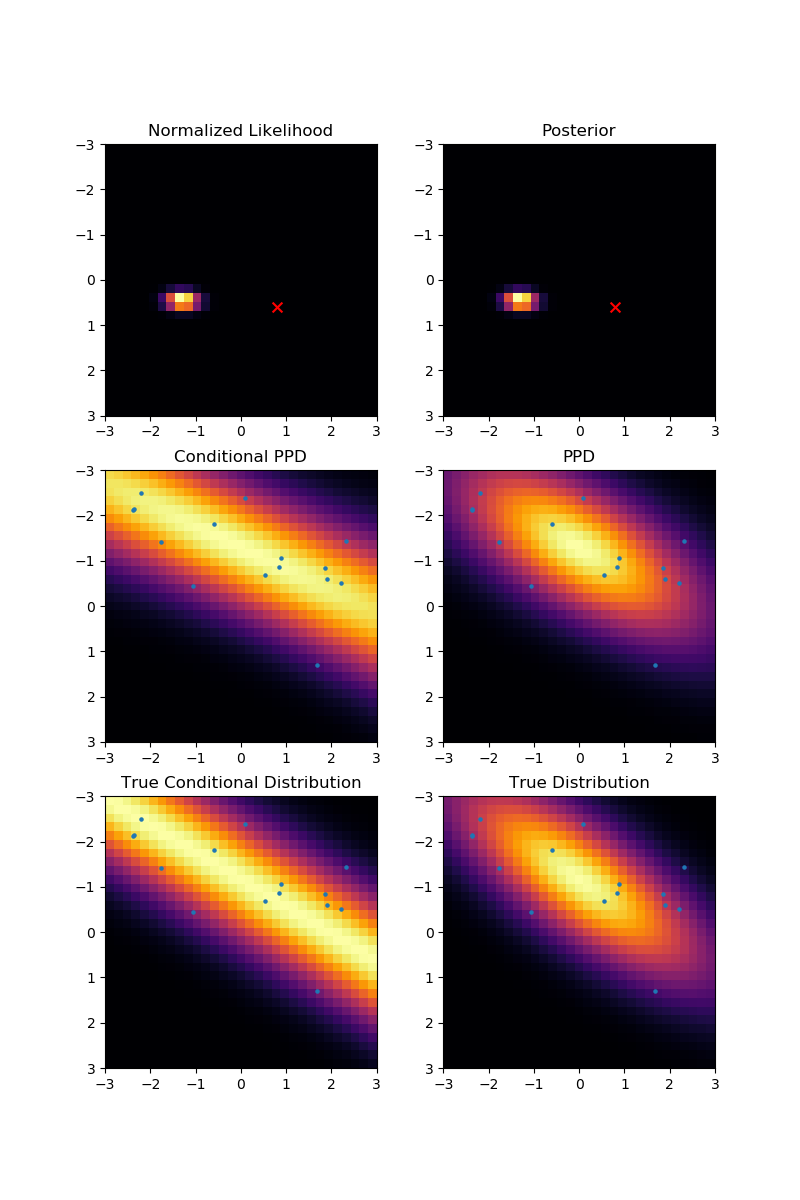

In [9]:
# PRZYKŁAD 4: CO SIĘ STANIE, JEŚLI SZUM MA NIEZEROWĄ ŚREDNIĄ, ALE MY O TYM NIE WIEMY?

# wybieramy rozkład na x'ach
x_distr = Normal(0., 2.)
# ustawiamy prawdziwy model: y = .6*x + .8 + N(-2.,1.)
true_params = np.array([.8, .6])
noise_distr = Normal(-2., 1.)
model_noise_distr = Normal(0., 1.)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=20,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
uniform_prior = np.full(shape=len(params), fill_value=1./len(params))
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=model_noise_distr,
    params=params,
    prior=uniform_prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)

100%|██████████| 20/20 [00:01<00:00, 12.90it/s]


<IPython.core.display.Javascript object>


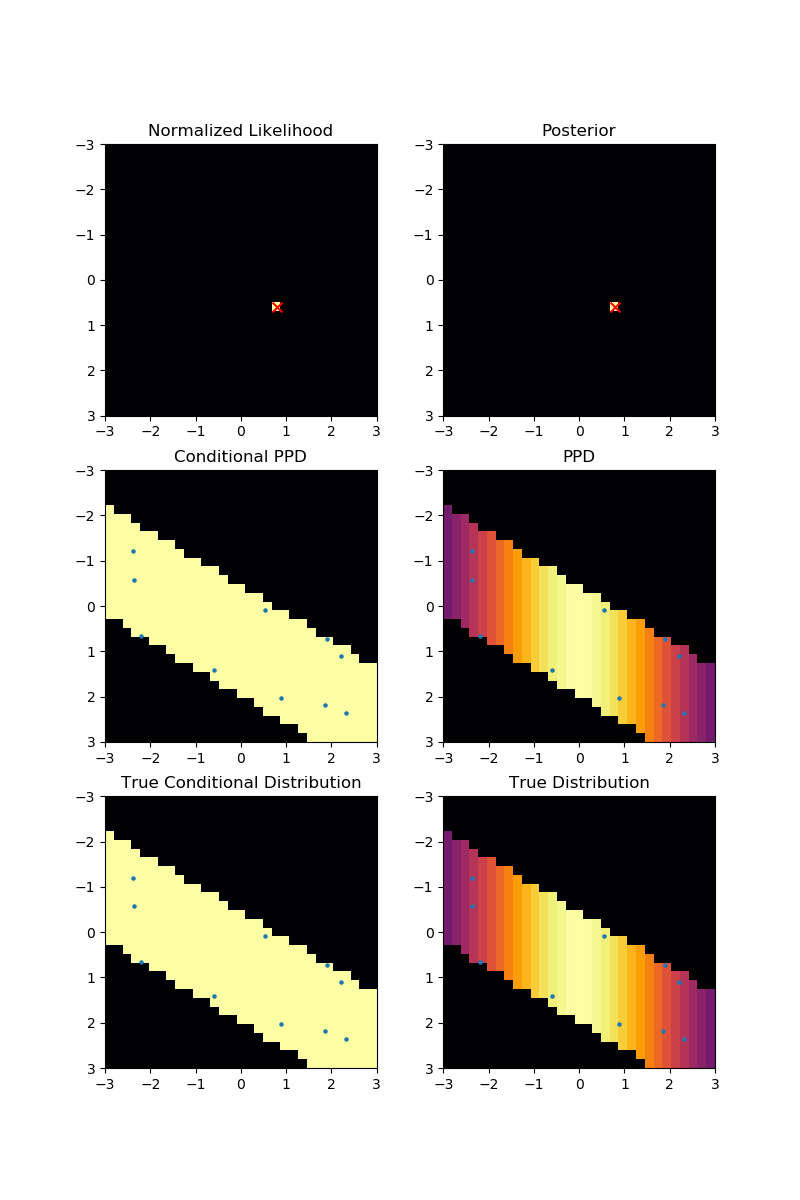

In [10]:
# PRZYKŁAD 5: CZY SZUM MUSI POCHODZIĆ Z ROZKŁADU NORMALNEGO?

# wybieramy rozkład na x'ach
x_distr = Normal(0., 2.)
# ustawiamy prawdziwy model: y = .6*x + .8 + U(0.,2.5)
true_params = np.array([.8, .6])
noise_distr = Uniform(0., 2.5)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=20,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
uniform_prior = np.full(shape=len(params), fill_value=1./len(params))
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=noise_distr,
    params=params,
    prior=uniform_prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)

100%|██████████| 20/20 [00:01<00:00, 13.17it/s]


<IPython.core.display.Javascript object>


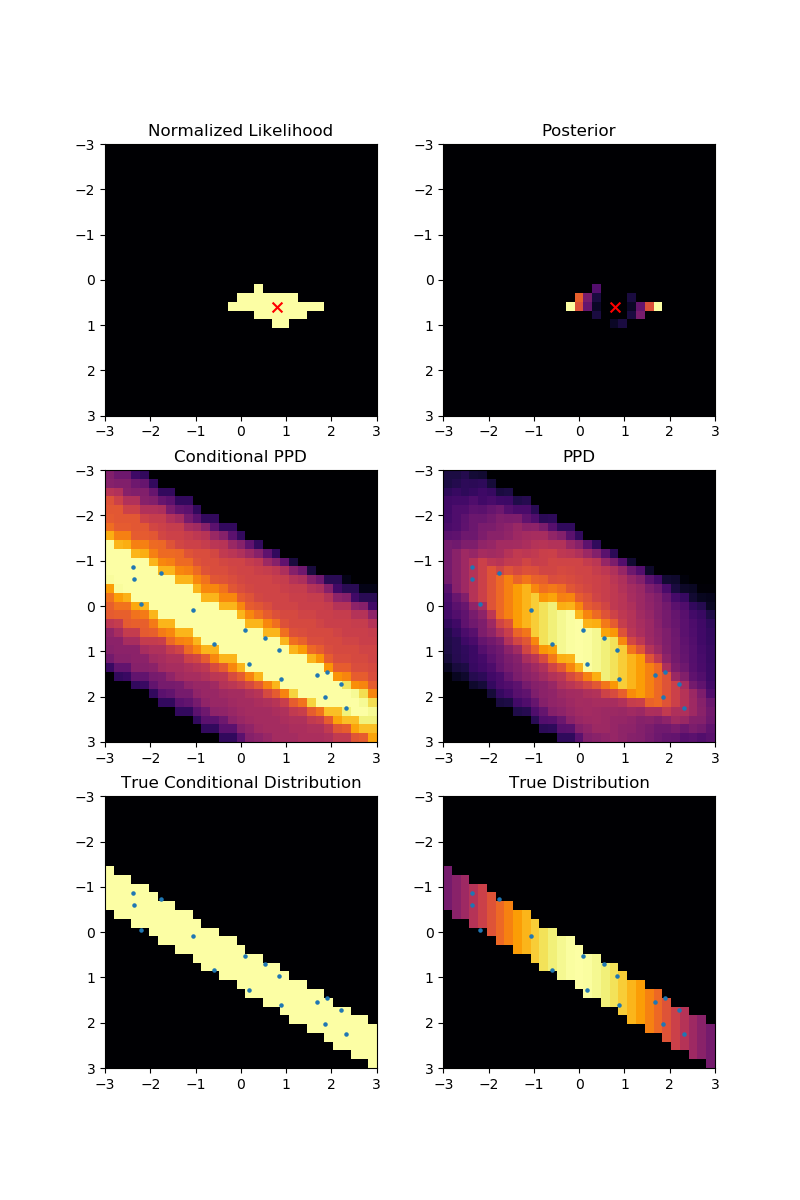

In [11]:
# PRZYKŁAD 6: JEDNOSTAJNY SZUM, MODEL ZAKŁADA WIĘKSZY SZUM, ZEROWY PRIOR W OTOCZENIU L2 PRAWDZIWEGO PARAMETRU

# wybieramy rozkład na x'ach
x_distr = Normal(0., 2.)
# ustawiamy prawdziwy model: y = .6*x + .8 + U(0.,1.)
true_params = np.array([.8, .6])
noise_distr = Uniform(0., 1.)
model_noise_distr = Uniform(0., 3.)
# wypisujemy gęstość prawdziwego rozkładu na siatce - rozbijamy na p(x) i p(y|x), bo p(x) przyda się później
true_x_pdf = x_distr.pdf(gridpoints_x).ravel()
true_conditional_pdf = noise_distr.pdf(gridpoints_y - (true_params[0] + true_params[1] * gridpoints_x)).ravel()
# generujemy obserwacje z prawdziwego rozkładu
obs_x, obs_y = generate_observations(
    params=true_params,
    x_distr=x_distr,
    noise_distr=noise_distr,
    n_samples=20,
    seed=43)
obs = np.hstack((obs_x, obs_y))
# wybieramy prior na parametrach rozkładów
prior = np.maximum(0., np.sum(np.square(params - true_params), axis=1) - .1)
prior /= prior.sum()
# tworzymy instancję estymatora
blr = BayesianLinearRegression(
    noise_distr=model_noise_distr,
    params=params,
    prior=prior)
# uczymy estymator
posteriors, ppds, likelihoods = learning_history(
    bayesian_linear_regression=blr,
    params=params,
    gridpoints_x=gridpoints_x,
    gridpoints_y=gridpoints_y,
    obs_x=obs_x,
    obs_y=obs_y)
# uruchamiamy animację
draw_animation(grid_description, true_params, posteriors, ppds, likelihoods, true_conditional_pdf, true_x_pdf, obs)